In [1]:
import numpy as np
import numpy.random as rd
import scipy as sp
import matplotlib.pyplot as plt
import time
from numba import jit
from numba import float64
%matplotlib inline
t1 = time.time()

In [2]:

def e_tot_corr(L,J,rede):
    soma = 0
    for i in range(L):
        for j in range(L):
            soma += rede[i,j]*(rede[(i+1)%L,j]+rede[(i-1)%L,j]+rede[i,(j+1)%L]+rede[i,(j-1)%L])
    return (J/2)*soma

def delta_E(L,rede, pos, B, beta, J, mu=1):
    x,y = pos
    
    xp, xm = x+1, x-1
    yp, ym = y+1, y-1 #vamos buscar as posições vizinhas
    
    sxp, sxm = rede[xp%L,y], rede[xm%L,y]
    syp, sym = rede[x,yp%L], rede[x,ym%L]
    
    inter_term = 2*J*rede[x,y]*(sxp+sxm+syp+sym)  #termo de interação
    dE = 2*mu*B*rede[x,y] - inter_term  #delta de Energia
    return np.exp(-beta*dE), dE

def metropolis_neel(L,N,B,beta,J,mu=1):
    rede = rd.randint(2,size=L**2)*2-1
    rede = rede.reshape(L,L)
    
    #Transformo o termo (-1)^(i+j) numa matriz
    A = np.ones(L**2)
    i=0
    while i<L:
        A[i*L+(i+1)%2:(i+1)*L:2] *= -1
        i+=1
    A = A.reshape(L,L)
    
    magn_neel = np.empty(N)
    magn = np.empty(N)
    en = np.empty(N)
    
    #No cálculo de mag Neél, multiplico termo a termo a matriz A_{ij} = (-1)^(i+j) com a matriz
    #dos spins, e somo todas as entradas.
    M_neel_in = abs(np.sum(np.multiply(A,rede)))
    
    magn_in = np.sum(rede)
    en_in = magn_in + e_tot_corr(L,J,rede)
    
    M_neel_f = M_neel_in
    for step in range(N):
        pos = (rd.randint(L), rd.randint(L))
        prob, dE = delta_E(L,rede,pos,B,beta,J)
        if rd.random() < prob:
            rede[pos[0],pos[1]] *= -1
            rede_flat = rede.flatten()
            rede_flat[1::2] *= -1
            M_neel_f =  abs(np.sum(np.multiply(A,rede)))
            magn_in += 2*mu*rede[pos[0],pos[1]]
            en_in += dE
        magn[step] =  magn_in
        en[step] =  en_in 
        magn_neel[step] =  M_neel_f
    return magn_neel/(L**2), magn/L**2 , en/L**2, rede

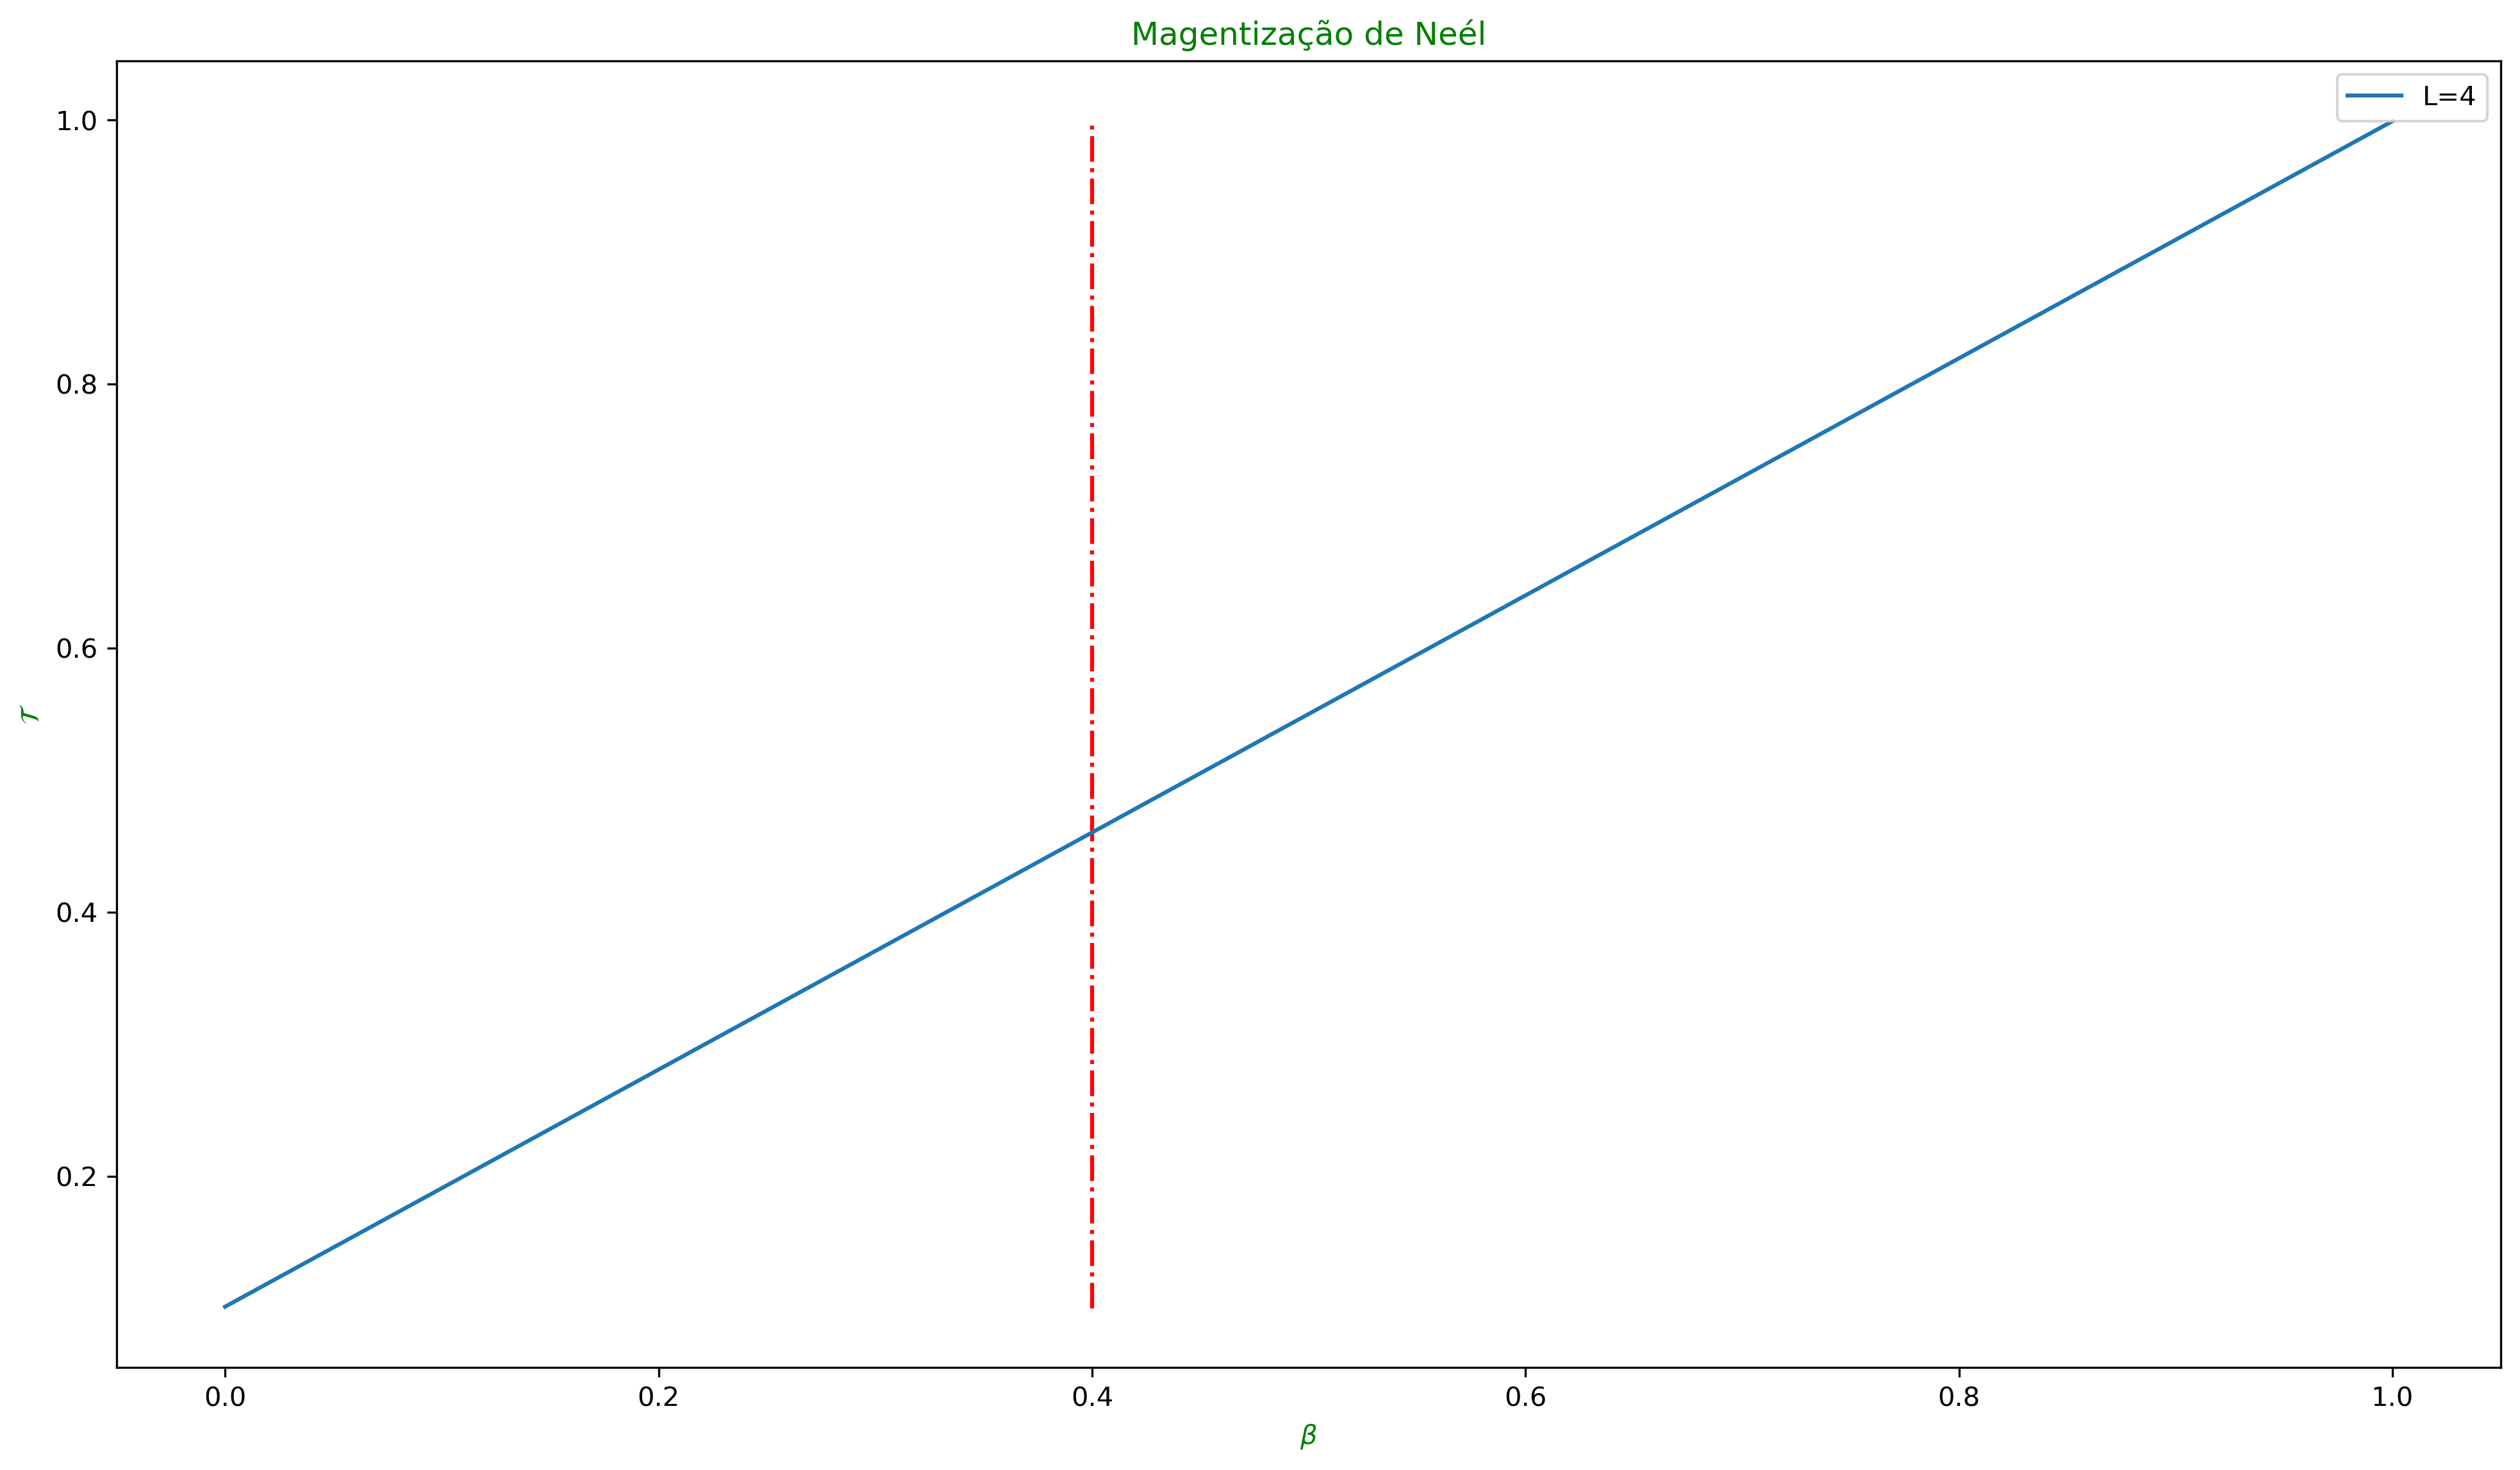

In [9]:
n_pontos = 2
betas = np.linspace(0,1,n_pontos)
B=0;J=1; N=100000

Ls = 8
arrays_m_neel_series_neel = np.empty((n_pontos,int(N)))

for k,i in enumerate(betas):
    arrays_m_neel_series_neel[k,:]= metropolis_neel(Ls,N,B,i,J)[0]
        
m_neel_med = np.empty(n_pontos)

for i in range(n_pontos):
    m_neel_med[i] = np.mean(arrays_m_neel_series_neel[i,10000:])#termalização de 1e4 passos
    
    
plt.figure(figsize=(16,9), dpi=300)
plt.title("Magentização de Neél", color="green")
plt.plot(betas,m_neel_med, label="L=4")
plt.vlines(0.4,0.1,1, linestyles="dashdot", colors="red")
plt.xlabel(r"$\beta$", color="green");plt.ylabel(r"$\mathcal{T}$", color="green")
plt.legend()
plt.show()